# 패키지 설치 및 데이터 인덱싱

In [32]:
import FinanceDataReader as fdr

In [33]:
df = fdr.DataReader('KS11','2014','2022-05-09') # 2014년부터 오늘까지 코스피 데이터 추출

In [34]:
data = df['Close'] 

In [35]:
data.isnull().sum()

0

# 자기상관분석

In [36]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

In [37]:
auto = pd.DataFrame(data)

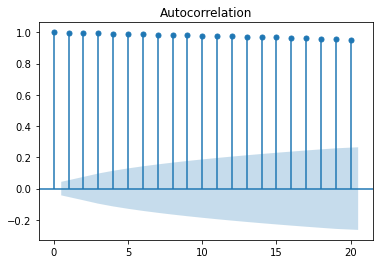

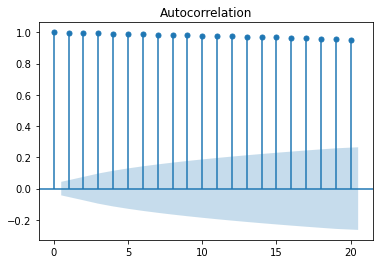

In [38]:
sm.graphics.tsa.plot_acf(auto['Close'],lags=20)

In [39]:
auto = auto.rename(columns={'Close':'당일종가'})

In [40]:
auto['전일종가'] = auto['당일종가'].shift()

In [41]:
auto

,당일종가,전일종가
Date,,
2014-01-02,1967.19,NaN
2014-01-03,1946.14,1967.19
2014-01-06,1953.28,1946.14
2014-01-07,1959.44,1953.28
2014-01-08,1958.96,1959.44
...,...,...
2022-05-02,2687.45,2695.05
2022-05-03,2680.46,2687.45
2022-05-04,2677.57,2680.46


In [42]:
auto['전일종가'][0] = 2011.34 # 결측치 제거를 위해 2013년 마지막 날 코스피 종가 데이터 입력

# log

In [43]:
auto['변동률'] = np.log(auto['당일종가']/auto['전일종가'])

In [44]:
auto

,당일종가,전일종가,변동률
Date,,,
2014-01-02,1967.19,2011.34,-0.022195
2014-01-03,1946.14,1967.19,-0.010758
2014-01-06,1953.28,1946.14,0.003662
2014-01-07,1959.44,1953.28,0.003149
2014-01-08,1958.96,1959.44,-0.000245
...,...,...,...
2022-05-02,2687.45,2695.05,-0.002824
2022-05-03,2680.46,2687.45,-0.002604
2022-05-04,2677.57,2680.46,-0.001079


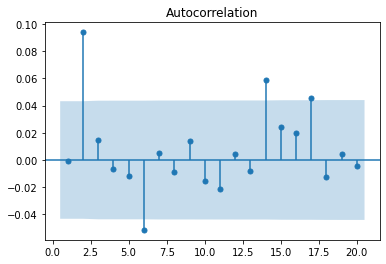

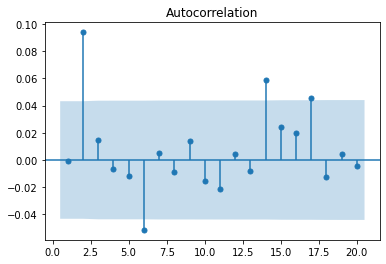

In [45]:
sm.graphics.tsa.plot_acf(auto['변동률'],lags=20, zero = False)

# acf / pacf / 정상성 검정

In [46]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

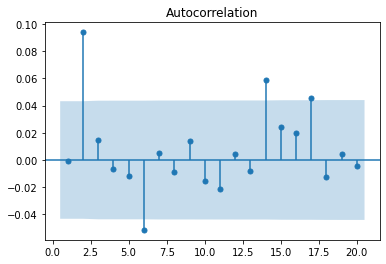

In [47]:
fig1 = plot_acf(auto['변동률'], lags=20, zero=False)

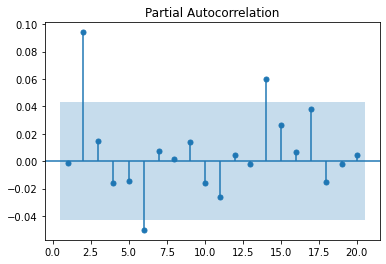

In [48]:
fig2 = plot_pacf(auto['변동률'],lags=20, zero=False)

In [49]:
result = adfuller(auto['변동률'])

In [50]:
print('ADF Statistic : {}'.format(result[0]))
print('p-value : {}'.format(result[1]))

ADF Statistic : -9.41377970369951
p-value : 5.741520912805788e-16


# ACF, PACF 그래프 확인

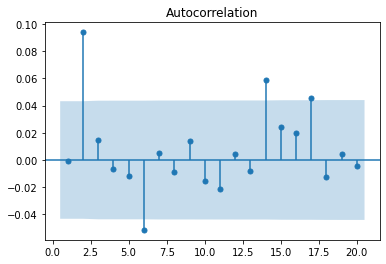

In [51]:
fig = plot_acf(auto['변동률'], lags=20, zero = False)

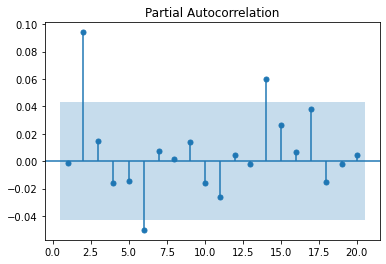

In [52]:
fig = plot_pacf(auto['변동률'],lags=20, zero = False)

ACF가 시차 0 이후에 0에 가까워지고, PACF도 시차 0 이후에 0에 가까워졌습니다.
AR = ACF가 빠르게 감소, PACF는 어느 시점에서 절단점을 가짐
MA = ACF가 절단점을 갖고, PACF는 빠르게 감소
ARMA = 둘 다 감소

log화를 했을 때 ACF와 PACF 모두 lag1에서 절단점을 가져서 AR MA를 판단하기가 어려워서, 최초 데이터로 1회 차분을 해보았습니다.

# 차분 ACF/PACF

In [53]:
df = fdr.DataReader('KS11','2014','2022-05-09') 
data = df['Close'] 
auto = pd.DataFrame(data)
auto = auto.rename(columns={'Close':'당일종가'})
auto['전일종가'] = auto['당일종가'].shift()
auto['전일종가'][0] = 2011.34

In [54]:
auto['변동률'] = (auto['당일종가']/auto['전일종가'])

In [55]:
auto

,당일종가,전일종가,변동률
Date,,,
2014-01-02,1967.19,2011.34,0.978049
2014-01-03,1946.14,1967.19,0.989299
2014-01-06,1953.28,1946.14,1.003669
2014-01-07,1959.44,1953.28,1.003154
2014-01-08,1958.96,1959.44,0.999755
...,...,...,...
2022-05-02,2687.45,2695.05,0.997180
2022-05-03,2680.46,2687.45,0.997399
2022-05-04,2677.57,2680.46,0.998922


In [56]:
x = auto['변동률']

In [57]:
x = np.diff(x) # 차분

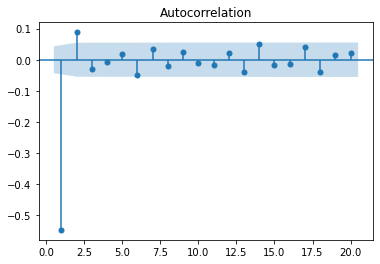

In [58]:
fig = plot_acf(x, lags=20, zero = False)

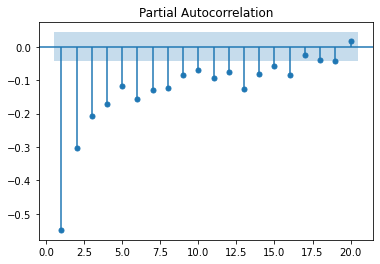

In [59]:
fig = plot_pacf(x, lags = 20, zero = False)

1차 차분 결과로 ACF와 PACF를 그려본 결과 ACF는 시차 2 이후 0에 가까운 모습을 확인할 수 있으며, PACF는 점차 감소하여 0에 접근하는 모습을 
확인할 수 있습니다. 즉 ACF는 lag 3에서 절단점을 가지고, pacf가 감소하기 때문에 변동률의 1차 차분 결과를 활용할 때는 MA(2)모델을 활용하는 것이 가장 높은 정확도를 보일 것이라고 추측할 수 있습니다.

In [60]:
result = adfuller(x)

In [61]:
print('ADF Statistic : {}'.format(result[0]))
print('p-value : {}'.format(result[1]))

ADF Statistic : -14.056921578030325
p-value : 3.105417662001218e-26


# auto-arima

In [62]:
# 데이터 준비

In [63]:
auto1 = auto

In [64]:
df.arima = pd.DataFrame(auto1['변동률'])

C:\Users\liked\AppData\Local\Temp/ipykernel_19656/2432600452.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.arima = pd.DataFrame(auto1['변동률'])


In [65]:
df.arima['date'] = df.arima.index # 데이터 분할을 위해 인덱스 활용, 날짜 컬럼 생성

In [66]:
df.arima['변동률'] = pd.to_numeric(df.arima['변동률'])

In [67]:
# train 데이터와 validation 데이터 분할
x_train = df.arima[df.arima['date'] < '2019-12-31']
x_valid = df.arima[(df.arima['date'] >= '2020-01-01')]

In [68]:
alpha = x_train[['date','변동률']]
alpha_v = x_valid[['date','변동률']]

In [69]:
print(x_train.shape)
print(x_valid.shape)

(1472, 2)
(581, 2)


In [70]:
# date를 데이터 프레임의 인덱스로 제작
alpha.set_index('date', inplace = True)
alpha_v.set_index('date', inplace = True)

In [71]:
import matplotlib.pyplot as plt
import pmdarima as pm

In [72]:
model = pm.auto_arima(y=alpha,
                     d = 1,
                     start_p = 0,
                     max_p = 3,
                     start_q = 0,
                     max_q = 3,
                     m = 1,
                     seasonal = False,
                     stepwide = True,
                     trace = True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-9207.872, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-9649.358, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-9998.059, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-9209.869, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-10172.979, Time=1.52 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-10168.017, Time=1.29 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.97 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-10062.750, Time=0.92 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-9798.816, Time=0.26 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-10161.479, Time=1.60 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.47 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 8.874 seconds


y = 데이터
d = 차분 차수
start_p, max_p : AR(p)를 찾을 범위
start_q, max_q : MA(q)를 찾을 범위
m = 계절적 차분이 필요할 때 쓸 수 있는 모수(m=4면 분기별, m = 12면 월별, m=1이면 계절적 특징을 띄지 않는 데이터
seasonal = 계절성 ARIMA 모형에 적합한지 여부
stepwise = 최적의 모수를 찾기 위해 쓰는 힌드만-칸다카르 알고리즘을 사용할지 여부
trace = stepwise로 모델을 적합할 때마다 결과를 프린트하고 싶을 때 사용


# 잔차 검정

In [73]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1472
Model:               SARIMAX(1, 1, 1)   Log Likelihood                5090.489
Date:                Thu, 26 May 2022   AIC                         -10172.979
Time:                        16:33:01   BIC                         -10151.804
Sample:                             0   HQIC                        -10165.083
                               - 1472                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.691e-06   2.39e-06     -0.707      0.480   -6.38e-06       3e-06
ar.L1          0.0081      0.025      0.323      0.747      -0.041       0.057
ma.L1         -0.9886      0.006   -175.533      0.0

Ljung-Box(융-박스 검정 통계량) : 잔차가 백색잡음인지 검정한 통계량, 많은 자기 상관 계수들이 동시에 0과 같은 값을 가진다는 귀무가설을 시험
Jarque-Bera(자크-베라 검정 통계량) : 잔차가 정규성을 띠는지 검정한 통계량, 왜도와 첨도가 정규분포로 보기에 적합한지에 대한 적합도 검정
Heteroskedasticity(이분산성 검정) : 오차항의 분산은 모든 관찰치에서 일정할 것
skew : 비대칭도
Kurtosis : 첨도
백색잡음 : 아무런 패턴이 남아있지 않은 무작위한 진동, 추세나 계절성이 남아있다면 백색잡음과는 멀어지고, 이를 검증하는 것이 잔차진단입니다.
백색잡음은 잔차률이 정규분포이고, 평균 0과 일정한 분산을 가져야하며, 시간의 흐름에 따라 상관성이 없어야 합니다.
즉, 잔차가 백색잡음 과정이면 정상성을 만족한다고 볼 수 있습니다.
잔차(residual)는 표본(sample)으로 추정한 회귀식과 실제 관측값의 차이를 말합니다.

현재 모델은 prob(Q)값을 보면 잔차가 백색잡음 시계열을 따르므로, 시계열 모형이 잘 적합되었고 남은 잔차는 더이상 자기상관을 가지지 않는 백색 잡음 임을 확인할 수 있습니다. prob(JB)는 0이므로 잔차가 정규성을 따르지 않음을 확인할 수 있습니다.


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


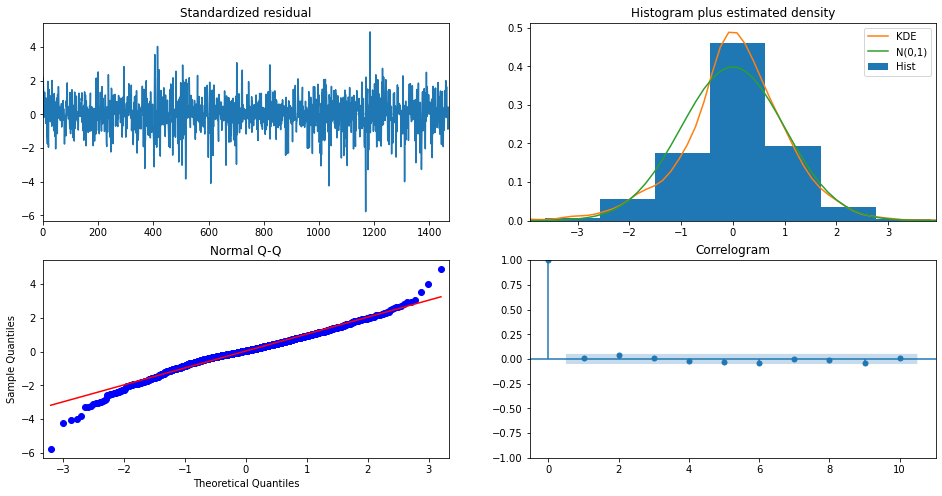

In [74]:
model.plot_diagnostics(figsize = (16,8))
plt.show()

Standardized residual - 잔차를 시계열로 그린 것, 백색 잡음일시 평균이 0을 중심으로 무작위하게 움직입니다.
Correlogram - 잔차에 대한 ACF 그래프

Histogram plus estimated density -  잔차의 히스토그램을 그려 정규 분포 N(0,1)과 밀도를 추정한 그래프를 같이 겹쳐서 보여주며, 비대칭도와 첨도에서 확인한 것처럼 정규분포와 비슷하게 대칭적이지만, 첨도가 더 뾰족하게 솟아오른 것을 알 수 있습니다.

Normal Q-Q - Q-Q 플랏으로 정규성을 만족한다면 빨간 일직선 위에 점들이 분포해야 한다. 현재 그림에서는 양 끝쪽에서 빨간 선을 벗어나는 형태를 보이고 있습니다.

적합한 ARIMA(1,1,1)로 남은 잔차는 백색 잡음이지만, 정규성은 따르지 않는다고 볼 수 있습니다.

# 모형 예측

In [75]:
alpha_p = model.predict(n_periods = len(alpha_v))

In [76]:
alpha_p = pd.DataFrame(alpha_p,index=alpha_v.index, columns=['Prediction'])

In [77]:
alpha_p.columns = {'change'}

In [78]:
alpha_p

,change
date,
2020-01-02,1.000359
2020-01-03,1.000384
2020-01-06,1.000383
2020-01-07,1.000381
2020-01-08,1.000379
...,...
2022-05-02,0.999404
2022-05-03,0.999402
2022-05-04,0.999401


# 모형 재검정

In [79]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1472
Model:               SARIMAX(1, 1, 1)   Log Likelihood                5090.489
Date:                Thu, 26 May 2022   AIC                         -10172.979
Time:                        16:33:02   BIC                         -10151.804
Sample:                             0   HQIC                        -10165.083
                               - 1472                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.691e-06   2.39e-06     -0.707      0.480   -6.38e-06       3e-06
ar.L1          0.0081      0.025      0.323      0.747      -0.041       0.057
ma.L1         -0.9886      0.006   -175.533      0.0

- 백색 잡음 : 아무런 패턴이 남아있지 않은 무작위한 진동
- 추세나 계절성이 남아있다면 백색잡음과는 멀어짐, 이를 검증하는 것이 잔차진단
- Ljung Box Test의 귀무가설은 잔차들이 백색 잡음이란 것이며, p-value가 0.05 미만일 경우 이를 기각합니다.
- 즉 ARIMA(1,1,1) 모형의 Ljung box test p-value는 0.65로, 귀무가설을 기각하지 못하기 때문에 잔차가 백색 잡음을 따름을 나타냅니다.
- https://direction-f.tistory.com/69 (LB)
- Jarque-Bera Test의 귀무가설은 '잔차는 정규분포를 한다'이고, p-value가 0.05 미만일 경우 이를 기각합니다.
- ARIMA(1,1,1) 모형의 Jarque-Bera Test p-value는 0.00으로, 귀무가설을 기각하기 때문에 잔차는 정규성을 따른다고 볼 수 없습니다.
- 탐색 결과, 저번주와 동일한 결과를 확인할 수 있었습니다.
- ARIMA(1,1,1)모형의 남은 잔차는 백색 잡음이지만, 정규성은 따르지 않는다고 볼 수 있습니다.

# 예측 모형 새로 제작

In [80]:
auto

,당일종가,전일종가,변동률
Date,,,
2014-01-02,1967.19,2011.34,0.978049
2014-01-03,1946.14,1967.19,0.989299
2014-01-06,1953.28,1946.14,1.003669
2014-01-07,1959.44,1953.28,1.003154
2014-01-08,1958.96,1959.44,0.999755
...,...,...,...
2022-05-02,2687.45,2695.05,0.997180
2022-05-03,2680.46,2687.45,0.997399
2022-05-04,2677.57,2680.46,0.998922


In [81]:
beta = auto[['변동률']]

In [82]:
beta = beta.reset_index(inplace=False,drop=True) 

In [83]:
beta.columns = {'change'}

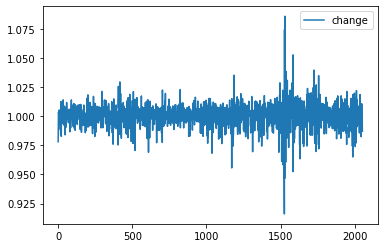

In [84]:
beta.plot()
plt.show()

In [85]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

In [86]:
model = ARIMA(beta.change.values, order = (1,1,1))
model_fit = model.fit(trend = 'c', full_output = True, disp = 1)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 2052
Model:                 ARIMA(1, 1, 1)   Log Likelihood                6552.300
Method:                       css-mle   S.D. of innovations              0.010
Date:                Thu, 26 May 2022   AIC                         -13096.600
Time:                        16:33:02   BIC                         -13074.094
Sample:                             1   HQIC                        -13088.347
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.947e-07   5.42e-06     -0.054      0.957   -1.09e-05    1.03e-05
ar.L1.D.y      0.0074      0.017      0.444      0.657      -0.025       0.040
ma.L1.D.y     -0.9759        nan        nan        n

In [87]:
model = ARIMA(beta.change.values, order = (1,1,1))
model_fit = model.fit(trend = 'nc', full_output = True, disp = 1)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 2052
Model:                 ARIMA(1, 1, 1)   Log Likelihood                6561.418
Method:                       css-mle   S.D. of innovations              0.010
Date:                Thu, 26 May 2022   AIC                         -13116.836
Time:                        16:33:03   BIC                         -13099.957
Sample:                             1   HQIC                        -13110.646
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.D.y     -0.0018      0.022     -0.082      0.934      -0.045       0.042
ma.L1.D.y     -0.9999      0.002   -616.628      0.000      -1.003      -0.997
                                    Roots           

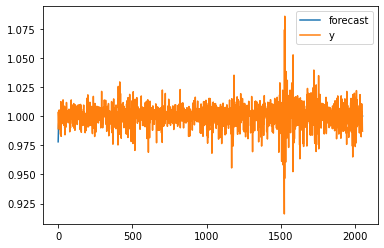

In [88]:
fig = model_fit.plot_predict()

In [89]:
model = ARIMA(beta.change.values, order = (0,0,2))
model_fit = model.fit(trend = 'nc', full_output = True, disp = True)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 2053
Model:                     ARMA(0, 2)   Log Likelihood                -296.944
Method:                       css-mle   S.D. of innovations              0.279
Date:                Thu, 26 May 2022   AIC                            599.887
Time:                        16:33:03   BIC                            616.768
Sample:                             0   HQIC                           606.077
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        1.7900      0.006    280.512      0.000       1.777       1.802
ma.L2.y        0.9390      0.006    144.891      0.000       0.926       0.952
                                    Roots           

In [90]:
model = ARIMA(beta.change.values, order = (0,0,2))
model_fit = model.fit(trend = 'nc', full_output = True, disp = 1)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 2053
Model:                     ARMA(0, 2)   Log Likelihood                -296.944
Method:                       css-mle   S.D. of innovations              0.279
Date:                Thu, 26 May 2022   AIC                            599.887
Time:                        16:33:03   BIC                            616.768
Sample:                             0   HQIC                           606.077
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        1.7900      0.006    280.512      0.000       1.777       1.802
ma.L2.y        0.9390      0.006    144.891      0.000       0.926       0.952
                                    Roots           

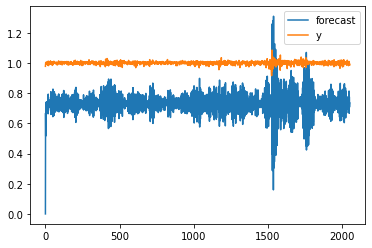

In [91]:
fig = model_fit.plot_predict()

# 테스트 데이터 생성

In [92]:
df1 = fdr.DataReader('KS11','2022-05-10','2022-05-17')

In [93]:
test = df1[['Close']]

In [94]:
test = test.rename(columns={'Close':'당일종가'})
test['전일종가'] = test['당일종가'].shift()

In [95]:
test['전일종가'][0] = 2610.81

In [96]:
test['change'] = (test['당일종가']/test['전일종가'])

In [97]:
test = test[['change']]

In [98]:
test['date'] = test.index

In [99]:
test['date'] = pd.to_datetime(test['date'])

In [100]:
test.set_index('date',inplace = True)

In [101]:
test

,change
date,
2022-05-10,0.994542
2022-05-11,0.998348
2022-05-12,0.983725
2022-05-13,1.021239
2022-05-16,0.997059
2022-05-17,1.009189


In [102]:
forecast_data = model_fit.forecast(steps=6)

In [103]:
pred_y = forecast_data[0].tolist() # 예측 데이터
test_y = test.change.values # 실제 데이터

In [104]:
pred_y_lower = []
pred_y_upper = []

In [105]:
for lower_upper in forecast_data[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)

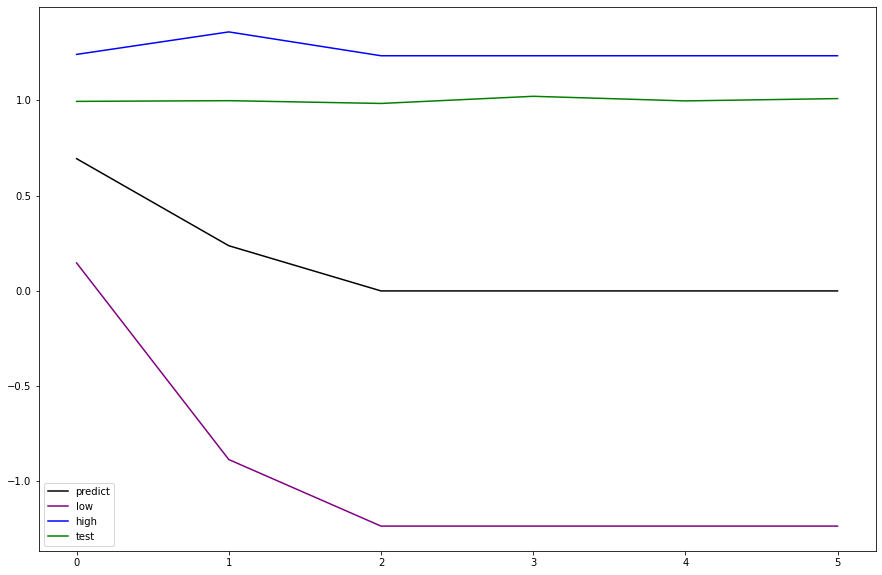

In [106]:
plt.figure(figsize=(15,10))
plt.plot(pred_y, color = 'black') # 6일 예측 데이터
plt.plot(pred_y_lower, color = 'purple') # 모델이 예측한 최저 변동률
plt.plot(pred_y_upper, color = 'blue') # 모델이 예측한 최고 변동률
plt.plot(test_y, color = 'green') # 실제 데이터
plt.legend(['predict','low','high','test'])
plt.show()

In [107]:
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 2053
Model:                     ARMA(0, 2)   Log Likelihood                -296.944
Method:                       css-mle   S.D. of innovations              0.279
Date:                Thu, 26 May 2022   AIC                            599.887
Time:                        16:33:05   BIC                            616.768
Sample:                             0   HQIC                           606.077
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        1.7900      0.006    280.512      0.000       1.777       1.802
ma.L2.y        0.9390      0.006    144.891      0.000       0.926       0.952
                                    Roots           

# 다시 처음부터 진행

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

In [109]:
df = fdr.DataReader('KS11','2014','2022-05-09') 
data = df['Close'] 
auto = pd.DataFrame(data)
auto = auto.rename(columns={'Close':'당일종가'})
auto['전일종가'] = auto['당일종가'].shift()
auto['전일종가'][0] = 2011.34
auto['변동률'] = (auto['당일종가']/auto['전일종가'])

In [110]:
auto1 = auto
df = pd.DataFrame(auto1['변동률'])

In [111]:
df['date'] = df.index

In [112]:
x_train = df[df['date'] < '2019-12-31']
x_valid = df[(df['date'] >= '2020-01-01')]

In [113]:
x_train.set_index('date',inplace = True)

In [114]:
x_valid.set_index('date',inplace = True)

In [115]:
a = x_train
b = x_valid

In [116]:
a.columns = {'change'}
b.columns = {'change'}

In [117]:
a.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1472 entries, 2014-01-02 to 2019-12-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   change  1472 non-null   float64
dtypes: float64(1)
memory usage: 23.0 KB


In [118]:
model = ARIMA(a,order = (1,1,1))

In [119]:
model_fit = model.fit(trend='c',full_output=True,disp=True)

In [120]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:               D.change   No. Observations:                 1471
Model:                 ARIMA(1, 1, 1)   Log Likelihood                5094.568
Method:                       css-mle   S.D. of innovations              0.008
Date:                Thu, 26 May 2022   AIC                         -10181.135
Time:                        16:33:08   BIC                         -10159.960
Sample:                             1   HQIC                        -10173.239
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -2.155e-08   4.74e-07     -0.045      0.964   -9.51e-07    9.08e-07
ar.L1.D.change     0.0219      0.026      0.839      0.401      -0.029       0.073
ma.L1.D.change    -0.9999      0.002

In [121]:
a_pred = model_fit.predict(1,1472,typ='levels')

In [122]:
a_pred.index = a.index

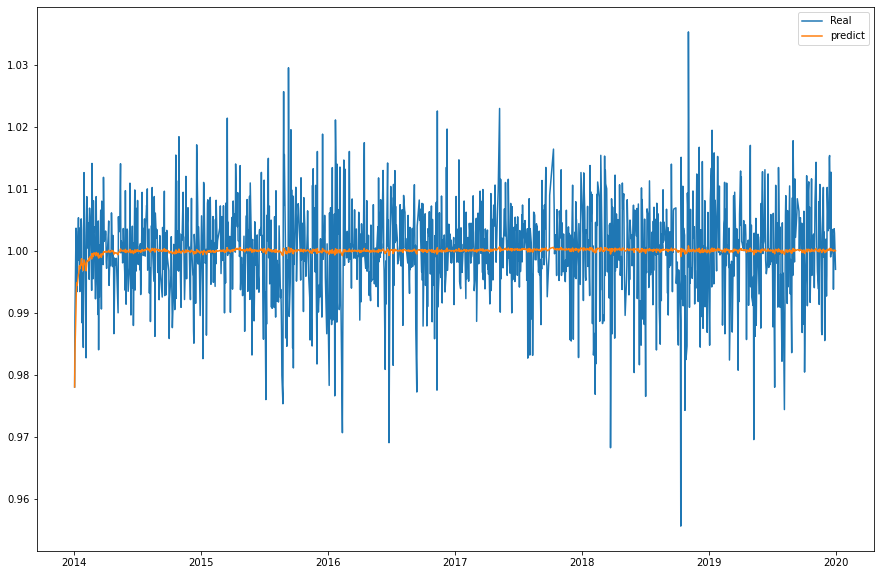

In [123]:
plt.figure(figsize=(15,10))
plt.plot(a,label = 'Real')
plt.plot(a_pred, label = 'predict')
plt.legend()
plt.show()

In [124]:
df

,변동률,date
Date,,
2014-01-02,0.978049,2014-01-02
2014-01-03,0.989299,2014-01-03
2014-01-06,1.003669,2014-01-06
2014-01-07,1.003154,2014-01-07
2014-01-08,0.999755,2014-01-08
...,...,...
2022-05-02,0.997180,2022-05-02
2022-05-03,0.997399,2022-05-03
2022-05-04,0.998922,2022-05-04


In [125]:
df_pred = model_fit.predict(1,2053,typ='levels')

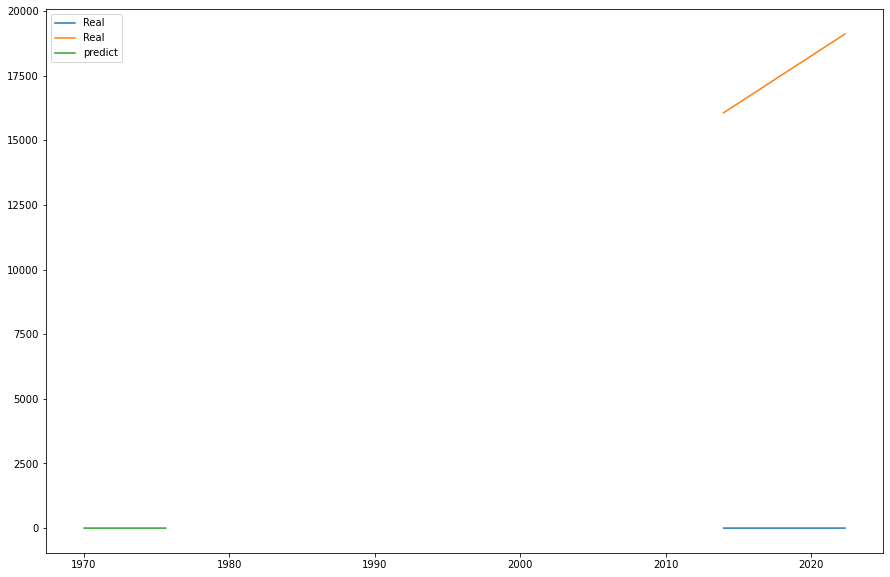

In [126]:
plt.figure(figsize=(15,10))
plt.plot(df,label = 'Real')
plt.plot(df_pred, label = 'predict')
plt.legend()
plt.show()

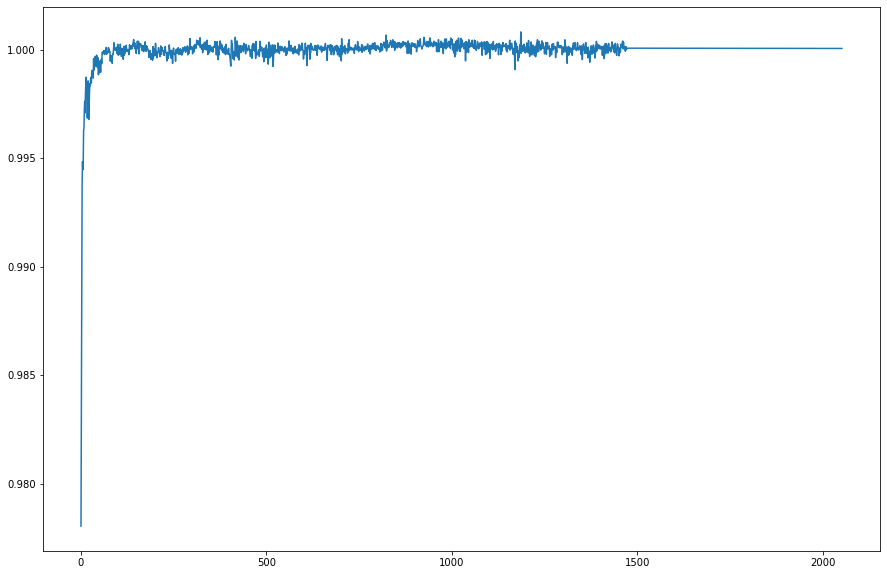

In [127]:
plt.figure(figsize=(15,10))
plt.plot(df_pred, label = 'predict') # ?

# MA(2) 모형으로 동일 과정 반복

In [128]:
model = ARIMA(a,order = (0,0,2))

In [129]:
model_fit = model.fit(trend='c',full_output=True,disp=True)

In [130]:
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                 change   No. Observations:                 1472
Model:                     ARMA(0, 2)   Log Likelihood                5103.406
Method:                       css-mle   S.D. of innovations              0.008
Date:                Thu, 26 May 2022   AIC                         -10198.811
Time:                        16:33:09   BIC                         -10177.634
Sample:                             0   HQIC                        -10190.914
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.0001      0.000   4784.067      0.000       1.000       1.000
ma.L1.change     0.0198      0.026      0.759      0.448      -0.031       0.071
ma.L2.change     0.0423      0.026      1.59

- 의미 없는 수치 이므로, 다른 방법 사용

In [131]:
model = ARIMA(a.change, order = (0,0,2))
model_fit = model.fit(trend = 'nc', full_output = True, disp = True)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                 change   No. Observations:                 1472
Model:                     ARMA(0, 2)   Log Likelihood                -181.120
Method:                       css-mle   S.D. of innovations              0.273
Date:                Thu, 26 May 2022   AIC                            368.241
Time:                        16:33:09   BIC                            384.124
Sample:                             0   HQIC                           374.163
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
ma.L1.change     1.8582      0.008    219.940      0.000       1.842       1.875
ma.L2.change     0.9389      0.007    133.543      0.000       0.925       0.953
                                    Roots   

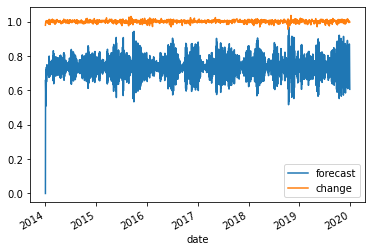

In [132]:
fig = model_fit.plot_predict()

# 전체 데이터셋을 동일한 방법으로 확인

In [133]:
model = ARIMA(df.변동률, order = (0,0,2))
model_fit = model.fit(trend = 'nc', full_output = True, disp = 1)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                    변동률   No. Observations:                 2053
Model:                     ARMA(0, 2)   Log Likelihood                -296.944
Method:                       css-mle   S.D. of innovations              0.279
Date:                Thu, 26 May 2022   AIC                            599.887
Time:                        16:33:09   BIC                            616.768
Sample:                             0   HQIC                           606.077
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.변동률      1.7900      0.006    280.512      0.000       1.777       1.802
ma.L2.변동률      0.9390      0.006    144.891      0.000       0.926       0.952
                                    Roots           

In [134]:
model = ARIMA(df.변동률, order = (0,0,2))
model_fit = model.fit(trend = 'nc', full_output = True, disp = True)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                    변동률   No. Observations:                 2053
Model:                     ARMA(0, 2)   Log Likelihood                -296.944
Method:                       css-mle   S.D. of innovations              0.279
Date:                Thu, 26 May 2022   AIC                            599.887
Time:                        16:33:09   BIC                            616.768
Sample:                             0   HQIC                           606.077
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.변동률      1.7900      0.006    280.512      0.000       1.777       1.802
ma.L2.변동률      0.9390      0.006    144.891      0.000       0.926       0.952
                                    Roots           

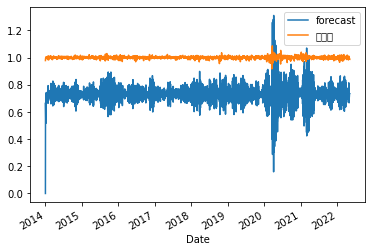

In [135]:
fig = model_fit.plot_predict()

In [136]:
fore = model_fit.forecast(steps=6)
print(fore) # 예측값, stderr, upper bound, lower bound

(array([0.69388702, 0.23711207, 0.        , 0.        , 0.        ,
       0.        ]), array([0.27920615, 0.57247019, 0.62964583, 0.62964583, 0.62964583,
       0.62964583]), array([[ 0.14665302,  1.24112101],
       [-0.88490887,  1.35913302],
       [-1.23408315,  1.23408315],
       [-1.23408315,  1.23408315],
       [-1.23408315,  1.23408315],
       [-1.23408315,  1.23408315]]))


In [137]:
test

,change
date,
2022-05-10,0.994542
2022-05-11,0.998348
2022-05-12,0.983725
2022-05-13,1.021239
2022-05-16,0.997059
2022-05-17,1.009189


# 추가

In [138]:
model = ARIMA(df.변동률, order = (1,1,1))
model_fit = model.fit(trend = 'c', full_output = True, disp = True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                  D.변동률   No. Observations:                 2052
Model:                 ARIMA(1, 1, 1)   Log Likelihood                6552.300
Method:                       css-mle   S.D. of innovations              0.010
Date:                Thu, 26 May 2022   AIC                         -13096.600
Time:                        16:33:10   BIC                         -13074.094
Sample:                             1   HQIC                        -13088.347
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -2.947e-07   5.42e-06     -0.054      0.957   -1.09e-05    1.03e-05
ar.L1.D.변동률     0.0074      0.017      0.444      0.657      -0.025       0.040
ma.L1.D.변동률    -0.9759        nan        nan    

In [139]:
model = ARIMA(df.변동률, order = (1,1,1))
model_fit = model.fit(trend = 'nc', full_output = True, disp = True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                  D.변동률   No. Observations:                 2052
Model:                 ARIMA(1, 1, 1)   Log Likelihood                6561.418
Method:                       css-mle   S.D. of innovations              0.010
Date:                Thu, 26 May 2022   AIC                         -13116.836
Time:                        16:33:10   BIC                         -13099.957
Sample:                             1   HQIC                        -13110.646
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
ar.L1.D.변동률    -0.0018      0.022     -0.082      0.934      -0.045       0.042
ma.L1.D.변동률    -0.9999      0.002   -616.628      0.000      -1.003      -0.997
                                    Roots       

- 무의미한 수치 확인

# 12주차

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

In [141]:
df = fdr.DataReader('KS11','2014','2022-05-23') 

In [142]:
df

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2014-01-02,1967.19,2013.11,2013.89,1967.19,207770000.0,-0.0220
2014-01-03,1946.14,1963.72,1964.63,1936.15,188530000.0,-0.0107
2014-01-06,1953.28,1947.62,1961.85,1943.74,193630000.0,0.0037
2014-01-07,1959.44,1947.65,1965.74,1947.08,193030000.0,0.0032
2014-01-08,1958.96,1965.50,1966.95,1950.02,217070000.0,-0.0002
...,...,...,...,...,...,...
2022-05-17,2620.44,2603.58,2621.84,2603.58,873520000.0,0.0092
2022-05-18,2625.98,2634.75,2644.13,2618.00,870270000.0,0.0021
2022-05-19,2592.34,2576.24,2597.79,2568.54,677600000.0,-0.0128


In [143]:
data = df['Close']

In [144]:
data = data.reset_index()

In [145]:
data

,Date,Close
0,2014-01-02,1967.19
1,2014-01-03,1946.14
2,2014-01-06,1953.28
3,2014-01-07,1959.44
4,2014-01-08,1958.96
...,...,...
2058,2022-05-17,2620.44
2059,2022-05-18,2625.98
2060,2022-05-19,2592.34
2061,2022-05-20,2639.29


In [146]:
data = data.rename(columns={'Close':'today'})
data['yesterday'] = data['today'].shift()

In [147]:
data['yesterday'][0] = 2011.34

In [148]:
data

,Date,today,yesterday
0,2014-01-02,1967.19,2011.34
1,2014-01-03,1946.14,1967.19
2,2014-01-06,1953.28,1946.14
3,2014-01-07,1959.44,1953.28
4,2014-01-08,1958.96,1959.44
...,...,...,...
2058,2022-05-17,2620.44,2596.58
2059,2022-05-18,2625.98,2620.44
2060,2022-05-19,2592.34,2625.98
2061,2022-05-20,2639.29,2592.34


In [149]:
data['change'] = (data['today']/data['yesterday'])

In [150]:
data['Date'] = pd.to_datetime(data['Date'])

In [151]:
sample = data[['Date','change']]

In [152]:
sample

,Date,change
0,2014-01-02,0.978049
1,2014-01-03,0.989299
2,2014-01-06,1.003669
3,2014-01-07,1.003154
4,2014-01-08,0.999755
...,...,...
2058,2022-05-17,1.009189
2059,2022-05-18,1.002114
2060,2022-05-19,0.987190
2061,2022-05-20,1.018111


In [153]:
train = sample[data['Date'] < '2020-01-01'][['Date','change']]

In [154]:
test = sample[data['Date'] > '2020-01-01'][['Date','change']]

In [155]:
train

,Date,change
0,2014-01-02,0.978049
1,2014-01-03,0.989299
2,2014-01-06,1.003669
3,2014-01-07,1.003154
4,2014-01-08,0.999755
...,...,...
1467,2019-12-23,0.999787
1468,2019-12-24,0.993815
1469,2019-12-26,1.003584
1470,2019-12-27,1.002857


In [156]:
test

,Date,change
1472,2020-01-02,0.989762
1473,2020-01-03,1.000593
1474,2020-01-06,0.990172
1475,2020-01-07,1.009499
1476,2020-01-08,0.988863
...,...,...
2058,2022-05-17,1.009189
2059,2022-05-18,1.002114
2060,2022-05-19,0.987190
2061,2022-05-20,1.018111


# auto-arima

In [157]:
train_index = train.set_index('Date')

In [158]:
test_index = test.set_index('Date')

In [159]:
model = pm.auto_arima(train_index['change'],
                     start_p = 0,
                     start_q = 0,
                     d=1,
                     max_p=5,
                     max_q=5,
                     m=1,
                     stepwise=True,
                     seasonal = False)

In [160]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1472
Model:               SARIMAX(1, 1, 1)   Log Likelihood                5090.489
Date:                Thu, 26 May 2022   AIC                         -10172.979
Time:                        16:33:20   BIC                         -10151.804
Sample:                             0   HQIC                        -10165.083
                               - 1472                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.691e-06   2.39e-06     -0.707      0.480   -6.38e-06       3e-06
ar.L1          0.0081      0.025      0.323      0.747      -0.041       0.057
ma.L1         -0.9886      0.006   -175.533      0.000      -1.000      -0.978
sigma2      5.699e-05   1.51e-06     37.777      0.000     5.4e-05       6e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):               319.87
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               1.37   Skew:                            -0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [161]:
fcast = model.predict(591)

In [162]:
fcast = pd.Series(fcast, index = test_index.index)

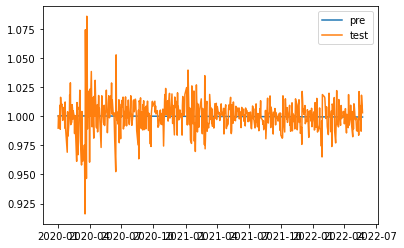

In [163]:
plt.plot(fcast, label = "pre")
plt.plot(test_index, label = "test")
plt.legend()

In [164]:
#prediction = []
#for i in fcast:
   # predict = model.predict(n_periods=1)[0]
   # prediction.append(predict)
   # model.update(i)

In [165]:
#train_index.plot()

In [166]:
test

,Date,change
1472,2020-01-02,0.989762
1473,2020-01-03,1.000593
1474,2020-01-06,0.990172
1475,2020-01-07,1.009499
1476,2020-01-08,0.988863
...,...,...
2058,2022-05-17,1.009189
2059,2022-05-18,1.002114
2060,2022-05-19,0.987190
2061,2022-05-20,1.018111


# arima

In [167]:
df.to_csv("kospi.csv")

In [168]:
df = pd.read_csv("kospi.csv", encoding = "cp949")

In [169]:
a = df[['Date','Close']]

In [170]:
a

,Date,Close
0,2014-01-02,1967.19
1,2014-01-03,1946.14
2,2014-01-06,1953.28
3,2014-01-07,1959.44
4,2014-01-08,1958.96
...,...,...
2058,2022-05-17,2620.44
2059,2022-05-18,2625.98
2060,2022-05-19,2592.34
2061,2022-05-20,2639.29


In [171]:
a = a.rename(columns={'Close':'today'})
a['yesterday'] = a['today'].shift()

In [172]:
a['yesterday'][0] = 2011.34

In [173]:
a['change'] = a['today']/a['yesterday']

In [174]:
a = a[['Date','change']]

In [175]:
a

,Date,change
0,2014-01-02,0.978049
1,2014-01-03,0.989299
2,2014-01-06,1.003669
3,2014-01-07,1.003154
4,2014-01-08,0.999755
...,...,...
2058,2022-05-17,1.009189
2059,2022-05-18,1.002114
2060,2022-05-19,0.987190
2061,2022-05-20,1.018111


In [176]:
from statsmodels.tsa.arima_model import ARIMA

In [177]:
change = ARIMA(a[['change']], order = (1,1,1))

In [178]:
change_fit = change.fit(trend = 'c', full_output = True, disp = 1)

In [179]:
print(change_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:               D.change   No. Observations:                 2062
Model:                 ARIMA(1, 1, 1)   Log Likelihood                6582.140
Method:                       css-mle   S.D. of innovations              0.010
Date:                Thu, 26 May 2022   AIC                         -13156.281
Time:                        16:33:21   BIC                         -13133.755
Sample:                             1   HQIC                        -13148.022
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            2.41e-08   5.36e-06      0.004      0.996   -1.05e-05    1.05e-05
ar.L1.D.change     0.0050      0.017      0.292      0.771      -0.028       0.038
ma.L1.D.change    -0.9759        nan

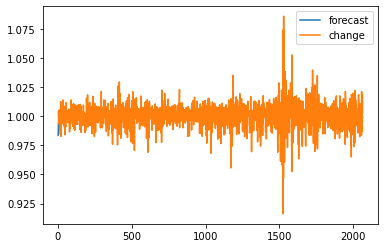

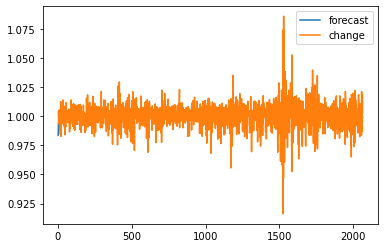

In [180]:
change_fit.plot_predict()

In [181]:
change = ARIMA(a['change'], order = (0,0,2))
change_fit = change.fit(trend = 'nc', full_output = True, disp = 1)
print(change_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                 change   No. Observations:                 2063
Model:                     ARMA(0, 2)   Log Likelihood                -298.250
Method:                       css-mle   S.D. of innovations              0.279
Date:                Thu, 26 May 2022   AIC                            602.501
Time:                        16:33:22   BIC                            619.396
Sample:                             0   HQIC                           608.695
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
ma.L1.change     1.7900      0.006    281.899      0.000       1.778       1.802
ma.L2.change     0.9392      0.006    145.061      0.000       0.926       0.952
                                    Roots   

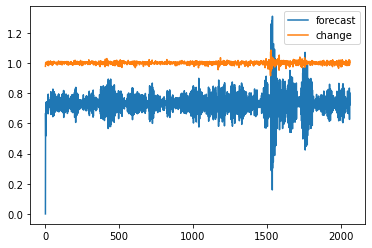

In [182]:
change_fit.plot_predict()
plt.show()

# 새로

In [183]:
a

,Date,change
0,2014-01-02,0.978049
1,2014-01-03,0.989299
2,2014-01-06,1.003669
3,2014-01-07,1.003154
4,2014-01-08,0.999755
...,...,...
2058,2022-05-17,1.009189
2059,2022-05-18,1.002114
2060,2022-05-19,0.987190
2061,2022-05-20,1.018111


In [184]:
a['Date'] = pd.to_datetime(a['Date'])

In [185]:
a = a.set_index('Date')

<AxesSubplot:xlabel='Date'>

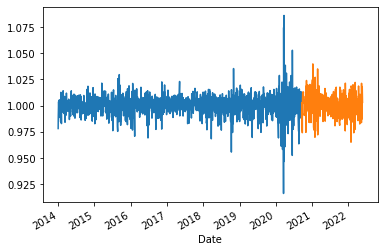

In [186]:
train = a['change'][:int(0.8*len(a))]
test = a['change'][int(0.8*len(a)):]
train.plot()
test.plot()

In [187]:
real = a['change'][0:int(len(a))]

In [188]:
model = pm.auto_arima(y = train       
                      , d = 1            
                      , start_p = 0 
                      , max_p = 3   
                      , start_q = 0 
                      , max_q = 3          
                      , seasonal = False 
                      , stepwise = True
                      , trace=True
                      )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-9447.064, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10094.647, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10465.155, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-9449.062, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-10595.323, Time=1.66 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-10548.786, Time=1.46 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-10513.290, Time=0.96 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-10597.159, Time=1.50 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-10528.703, Time=0.75 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.27 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.56 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 9.925 seconds


In [189]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1650
Model:               SARIMAX(0, 1, 2)   Log Likelihood                5302.580
Date:                Thu, 26 May 2022   AIC                         -10597.159
Time:                        16:33:32   BIC                         -10575.527
Sample:                             0   HQIC                        -10589.139
                               - 1650                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -1.02e-06   2.74e-06     -0.373      0.710   -6.39e-06    4.35e-06
ma.L1         -0.9968      0.008   -120.311      0.000      -1.013      -0.981
ma.L2          0.0069      0.009      0.791      0.4

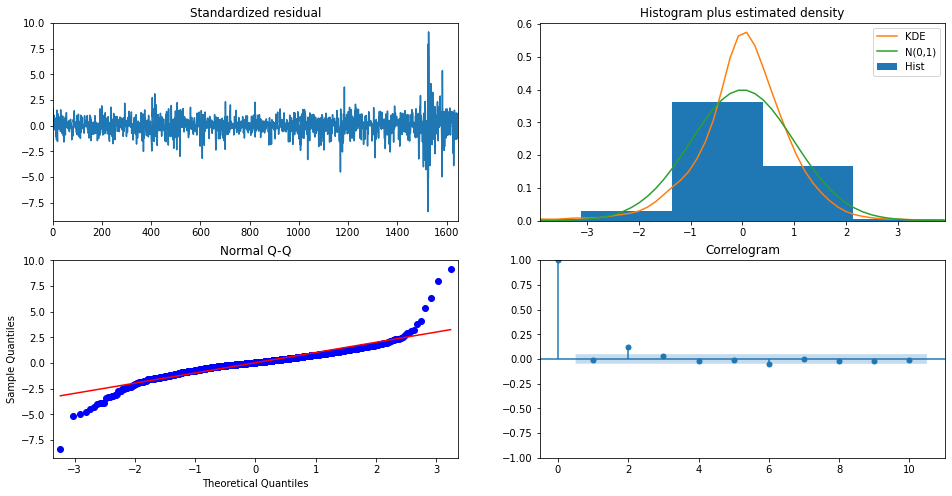

In [190]:
model.plot_diagnostics(figsize=(16, 8))
plt.show()

In [191]:
y_predict = model.predict(n_periods = len(test))
y_predict = pd.DataFrame(y_predict, index = test.index, columns = ['predict'])

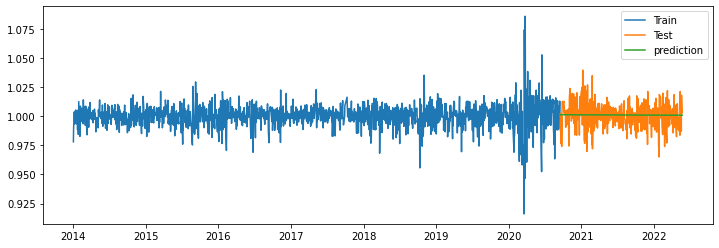

In [192]:
fig, axes = plt.subplots(1,1, figsize = (12,4))
plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')
plt.plot(y_predict, label = 'prediction')
plt.legend()
plt.show()

In [193]:
def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1 
        , return_conf_int=True)              
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0]
    )

In [194]:
forecasts = []
y_pred = []
pred_upper = []
pred_lower = []

for new_ob in test:
    fc, conf = forecast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])
    
    model.update(new_ob) # 모형 업데이트

In [195]:
pd.DataFrame({"test":test,"pred":y_pred})

,test,pred
Date,,
2020-09-17,0.987787,1.001365
2020-09-18,1.002589,1.001290
2020-09-21,0.990462,1.001200
2020-09-22,0.976228,1.001173
2020-09-23,1.000279,1.001018
...,...,...
2022-05-17,1.009189,0.999094
2022-05-18,1.002114,0.999113
2022-05-19,0.987190,0.999190


In [196]:
# !pip install plotly==5.4.0

In [197]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [1]:
fig = go.Figure([
    # 훈련 데이터-------------------------------------------------------
    go.Scatter(x = train.index, y = train, name = "Train", mode = 'lines'
              ,line=dict(color = 'royalblue'))
    # 테스트 데이터------------------------------------------------------
    , go.Scatter(x = test.index, y = test, name = "Test", mode = 'lines'
                ,line = dict(color = 'rgba(0,0,30,0.5)'))
    # 예측값-----------------------------------------------------------
    , go.Scatter(x = test.index, y = y_pred, name = "Prediction", mode = 'lines'
                     ,line = dict(color = 'red', dash = 'dot', width=3))
    # 신뢰 구간---------------------------------------------------------
    , go.Scatter(x = test.index.tolist() + test.index[::-1].tolist() 
                ,y = pred_upper + pred_lower[::-1] ## 상위 신뢰 구간 -> 하위 신뢰 구간 역순으로
                ,fill='toself'
                ,fillcolor='rgba(0,0,30,0.1)'
                ,line=dict(color='rgba(0,0,0,0)')
                ,hoverinfo="skip"
                ,showlegend=False)
    
])

fig.update_layout(height=400, width=1000, title_text="ARIMA(0,1,2)모형")
fig.show()

NameError: name 'go' is not defined

In [168]:
def MAPE(test, y_pred):
	return np.mean(np.abs((test - y_pred) / test)) * 100 
    
print(f"MAPE: {MAPE(test, y_pred):.3f}")

MAPE: 0.827


# MA(2)

In [169]:
from statsmodels.tsa.arima_model import ARMA

In [170]:
mod = ARMA(real, order = (0,2))
res = mod.fit()

In [171]:
print(res.summary())

                              ARMA Model Results                              
Dep. Variable:                 change   No. Observations:                 2063
Model:                     ARMA(0, 2)   Log Likelihood                6608.378
Method:                       css-mle   S.D. of innovations              0.010
Date:                Thu, 26 May 2022   AIC                         -13208.756
Time:                        11:07:00   BIC                         -13186.228
Sample:                             0   HQIC                        -13200.497
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.0002      0.000   4246.599      0.000       1.000       1.001
ma.L1.change    -0.0073      0.022     -0.334      0.738      -0.050       0.036
ma.L2.change     0.0956      0.022      4.36

In [172]:
print(res.params)

const           1.000182
ma.L1.change   -0.007336
ma.L2.change    0.095591
dtype: float64


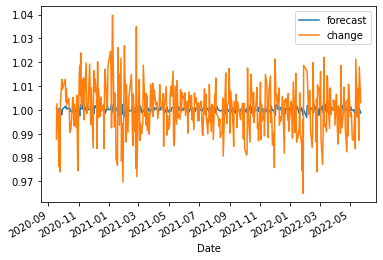

In [217]:
res_pred = res.plot_predict(start = len(train), end = len(dm)-1)

# 또 다른 방법

In [6]:
from pandas import datetime
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

C:\Users\liked\AppData\Local\Temp/ipykernel_19656/1713635818.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [7]:
def parser(x):
    return datetime.strptime(x, "%Y-%m-%d")

In [8]:
series = read_csv('kospi.csv', header=0, index_col=0, parse_dates=True, squeeze=True, date_parser=parser)

In [9]:
series.index = series.index.to_period('D')

In [10]:
series['change'] = series['Close']/series['Open']

In [11]:
series = series['change']

In [12]:
series

Date
2014-01-02    0.977190
2014-01-03    0.991048
2014-01-06    1.002906
2014-01-07    1.006053
2014-01-08    0.996673
                ...   
2022-05-17    1.006476
2022-05-18    0.996671
2022-05-19    1.006249
2022-05-20    1.012860
2022-05-23    0.998397
Freq: D, Name: change, Length: 2063, dtype: float64

In [25]:
size = int(len(series) * 0.8)
train, test = X[0:size], X[size:len(X)]

In [26]:
history = [x for x in train]
predictions = list()

In [27]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [28]:
for t in range(len(test)):
    model = ARIMA(history, order=(0,1,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
print('predicted=%f, expected=%f' % (yhat, obs))

predicted=0.998955, expected=0.998397


In [29]:
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.009


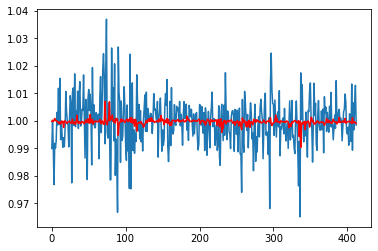

In [30]:
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

#ㅇ